In [1]:
from Bio import PDB
from Bio.PDB import PDBIO, Select
import pandas as pd
from copy import copy

parser = PDB.PDBParser(QUIET=True)

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import Compute2DCoords

import numpy as np
import subprocess
import shutil
import os

In [3]:
from Bio import Align
from Bio.SubsMat import MatrixInfo as matlist
import numpy as np
from tqdm import tqdm
from Bio.PDB.StructureBuilder import StructureBuilder

def Needleman_Wunsch_alignment(seq1,seq2):
    '''
    Function for doing global alignment between seq1 and seq2 using Needleman-Wunsch algorithm implemented in Biopython
    '''
    missing=None
    if "-" in seq1:
        # Need to handle "-" beforehand, otherwise the alignment may fail
        missing=[s=="-" for s in seq1]
        seq1=seq1.replace("-","")
    aligner=Align.PairwiseAligner()
    aligner.open_gap_score=-10
    aligner.extend_gap_score=-0.5
    aligner.substitution_matrix=matlist.blosum62
    alignment=aligner.align(seq1,seq2)[0]
    alignment_info=alignment.__str__().split("\n")
    aligned1,aligned2=alignment_info[0],alignment_info[2]
    if missing is None:
        final1=aligned1
        final2=aligned2
    else:
        # Assign alignment with "-"
        final1_temp=""
        final2_temp=""
        j=0
        for s in missing:
            if s:
                final1_temp+="-"
                final2_temp+="-"
            else:
                while aligned1[j]=="-" and j<len(aligned1):
                    final1_temp+=aligned1[j]
                    final2_temp+=aligned2[j]
                    j+=1
                if j<len(aligned1):
                    final1_temp+=aligned1[j]
                    final2_temp+=aligned2[j]
                    j+=1
        if j<len(aligned1):
            final1_temp+=aligned1[j:]
            final2_temp+=aligned2[j:]
        # Cleaning up
        final1=""
        final2=""
        for i in range(len(final1_temp)):
            if not (final1_temp[i]=="-" and final2_temp[i]=="-"):
                final1+=final1_temp[i]
                final2+=final2_temp[i]
    return final1,final2

        
def calc_seq_align_identity(seq1,seq2):
    if seq1 in seq2 or seq2 in seq1:
        return 1
    aseq1,aseq2=Needleman_Wunsch_alignment(seq1,seq2)
    assert len(aseq1)==len(aseq2)
    while aseq1[0]=="-" or aseq2[0]=="-":
        aseq1=aseq1[1:]
        aseq2=aseq2[1:]
    while aseq1[-1]=="-" or aseq2[-1]=="-":
        aseq1=aseq1[:-1]
        aseq2=aseq2[:-1]

    same_count = 0
    aligned_count = 0
    for i in range(len(aseq1)):
        if aseq1[i]=="-" or aseq2[i]=="-":
            continue
        aligned_count+=1
        if aseq1[i]==aseq2[i]:
            same_count+=1
    if aligned_count / len(aseq1) < 0.6:
        return -1
        
    
    return same_count/aligned_count

def get_min_dist_between_lig_and_chain(ligand, chain):
    ligand_coords = ligand.GetConformer().GetPositions()
    chain_CA_coords = np.array([res["CA"].get_coord() for res in chain if PDB.Polypeptide.is_aa(res)])
    # minimum distance between ligand and chain
    min_dist = np.min(np.linalg.norm(ligand_coords[:, None, :] - chain_CA_coords[None, :, :], axis=-1))
    return min_dist


class AAOnly(Select):
    def accept_residue(self, residue):
        return PDB.Polypeptide.is_aa(residue)
    
    def accept_atom(self, atom):
        if not atom.is_disordered() or atom.get_altloc() == "A":
            atom.set_altloc(" ")
            return True
        return False

class AltlocSelect(Select):
    
    def accept_atom(self, atom):
        if not atom.is_disordered() or atom.get_altloc() == 'A':
            return True
        return False
    



def save_multiple_chains(list_of_chains, save_addr, selector=None):
    sb = StructureBuilder()
    sb.init_structure("pdb")
    sb.init_seg(" ")
    sb.init_model(0)
    
    for chain in list_of_chains:
        sb.structure[0].add(chain)

    io = PDB.PDBIO()
    io.set_structure(sb.structure)
    io.save(save_addr, select=selector)


def write_alignment(seq1, seq2, out_file):
    aseq1, aseq2 = Needleman_Wunsch_alignment(seq1, seq2)
    seq1_line = ""
    seq2_line = ""
    final_lines = []
    for i in range(len(aseq1)):
        if i % 150 == 0:
            final_lines.append(seq1_line + "\n")
            final_lines.append(seq2_line + "\n")
            final_lines.append("\n")
            seq1_line = ""
            seq2_line = ""
        if aseq1[i] == "-" or aseq2[i] == "-":
            seq1_line += aseq1[i]
            seq2_line += aseq2[i]
        elif aseq1[i] == aseq2[i]:
            seq1_line += aseq1[i]
            seq2_line += aseq2[i]
        else:
            seq1_line += '\033[31m' + aseq1[i] + '\033[0m'
            seq2_line += '\033[31m' + aseq2[i] + '\033[0m'
    
    with open(out_file, "w") as f:
        f.writelines(final_lines)


In [4]:

ignored_list = ["HOH", "PO4"]
min_dist_threshold = 5

In [5]:
df=pd.read_csv("prepared.csv",index_col=0)

In [6]:
df

,value,smiles,seq
pdbid,,,
6TRX,14,NC(CC(=O)N1CCN(CC1)C(c1ccc(F)cc1)c1ccc(F)cc1)C...,MWKRSEQMKIKSGKCNMAAAMETEQLGVEIFETADCEENIESQDRP...
7LQZ,65,COc1cc(CC(=O)OCC2=C[C@H]3[C@H]4OC5(Cc6ccccc6)O...,MKKWSSTDLGAAADPLQKDTCPDPLDGDPNSRPPPAKPQLSTAKSR...
7T6S,44,CC(C)c1c(NC(=O)Nc2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,METNFSTPLNEYEEVSYESAGYTVLRILPLVVLGVTFVLGVLGNGL...
7SHV,0.13,OCCn1cc(c(n1)-c1ccncc1)-c1ccc2C(CCc2c1)N=O,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...
6LR4,28,CC(C)[C@H](O)C(=O)N[C@@H](C)C(=O)N[C@H]1c2cccc...,MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGH...
...,...,...,...
7LR0,20,COc1cc(CNC(=O)CCCC\C=C\C(C)C)ccc1O,MKKWSSTDLGAAADPLQKDTCPDPLDGDPNSRPPPAKPQLSTAKSR...
7EW2,5.9,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(O)(O)=O)cc1,MATALPPRLQPVRGNETLREHYQYVGKLAGRLKEASEGSTLTTVLF...
5SIJ,1.8,Cc1cnc(C)c2nc(CCc3nc(cn3C)-c3ccccc3)nn12,MRIEERKSQHLTGLTDEKVKAYLSLHPQVLDEFVSESVSAETVEKW...


In [7]:
import os
os.mkdir("dataset")

FileExistsError: [Errno 17] File exists: 'dataset'

In [8]:
import urllib

def get_pdb(pdbid):
    pdbl = PDB.PDBList()
    pdbl.retrieve_pdb_file(pdbid, pdir=f"dataset/{pdbid}", file_format="pdb")
    if not os.path.exists(f"dataset/{pdbid}/pdb{pdbid.lower()}.ent"):
        print("Download and convert .cif file")
        os.makedirs(f"dataset/{pdbid}_IP", exist_ok=True)
        # use urlretrieve to get the .cif file
        url = f"https://files.rcsb.org/download/{pdbid}.cif"
        urllib.request.urlretrieve(url, f"dataset/{pdbid}_IP/{pdbid}.cif")

        # convert .cif to .pdb
        subprocess.run(["obabel", f"dataset/{pdbid}_IP/{pdbid}.cif", "-O", f"dataset/{pdbid}/pdb{pdbid.lower()}.ent"])


In [9]:
def process_pdb(pdbid, maximum_chain_dist=min_dist_threshold):
    get_pdb(pdbid)
    struc=parser.get_structure(pdbid, f"dataset/{pdbid}/pdb{pdbid.lower()}.ent")

    os.makedirs(f"dataset/{pdbid}_IP", exist_ok=True)
    # get chain sequences
    seqs={}
    for chain in struc[0].child_dict.values():
        seqs[chain.id]="".join([PDB.Polypeptide.three_to_one(res.get_resname()) for res in chain.get_residues() if PDB.Polypeptide.is_aa(res, standard=True)])

    
    # get ligand from pdb
    interesting_ligand_id = 0
    for residue in struc[0].get_residues():
        if not PDB.Polypeptide.is_aa(residue, standard=True):
            print(residue.get_resname())
            if residue.get_resname() not in ignored_list and len(residue.child_list) > 1:
                copied_residue = residue.copy()
                # save residue as ligand
                try:
                    io = PDB.PDBIO()
                    io.set_structure(residue)
                    io.save(f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.pdb", AltlocSelect())
                except:
                    io = PDB.PDBIO()
                    io.set_structure(copied_residue)
                    io.save(f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.pdb")
                subprocess.call(["obabel", f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.pdb", "-O", f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.sdf"])
                interesting_ligand_id += 1

    ligands = []
    for i in range(interesting_ligand_id):
        mol = Chem.MolFromMolFile(f"dataset/{pdbid}_IP/lig_{i}.sdf", sanitize=False)
        mol_noH = Chem.RemoveHs(mol, sanitize=False)
        Chem.rdmolops.SanitizeMol(mol_noH, 268435455-2)
        ligands.append(mol_noH)

    if len(ligands) == 0:
        print(f"Warning! No ligands found for {pdbid}!")
        return None

    ref_mol=Chem.MolFromSmiles(df.loc[pdbid]["smiles"])
    ref_mol_fp=AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=1024)

    # get all similarities
    similarity = [Chem.DataStructs.DiceSimilarity(ref_mol_fp, AllChem.GetMorganFingerprintAsBitVect(ligand, 2,nBits=1024)) for ligand in ligands]
    chosen_ligand_idx = np.argmax(similarity)
    chosen_ligand = Chem.RemoveHs(ligands[chosen_ligand_idx], sanitize=False)

    if chosen_ligand.GetNumAtoms() != ref_mol.GetNumAtoms():
        print(f"Warning! Best matched ligand has different number of heavy atoms for {pdbid}!")
        return chosen_ligand, ref_mol

    fixed_ligand = AllChem.AssignBondOrdersFromTemplate(ref_mol, chosen_ligand)
    Chem.MolToMolFile(fixed_ligand, f"dataset/{pdbid}/ligand.sdf")

    # if similarity[chosen_ligand_idx] < 0.8:
    #     print(f"Warning! Best matched ligand is not similar for {pdbid}!")
    #     titles = ["ref_mol"] + [f"ligand_{i}" + ("(selected)" if i == chosen_ligand_idx else "")\
    #                              for i in range(len(ligands))]
    #     proc_ligs = []
    #     for lig in ligands:
    #         copied_lig = copy(lig)
    #         AllChem.Compute2DCoords(copied_lig)
    #         proc_ligs.append(Chem.RemoveHs(copied_lig,sanitize=False))
    #         img = Draw.MolsToGridImage([ref_mol] + proc_ligs, legends=titles, molsPerRow=5, subImgSize=(300,300))
    #     img.save(f"dataset/{pdbid}/alternative_ligands.png")
    
    # chosen_ligand_idx = np.argmax(similarity)

    ref_chain_seq = df.loc[pdbid]["seq"]
    seq_sims = {}
    for chain_id in seqs:
        seq_sims[chain_id] = calc_seq_align_identity(ref_chain_seq, seqs[chain_id])


    satisfied_chains = []
    satisfied_chain_sims = []
    for seqid in seqs:
        if len(seqs[seqid]) == 0:
            continue
        min_dist = get_min_dist_between_lig_and_chain(fixed_ligand, struc[0][seqid])
        print("chain", seqid, "min_dist", min_dist)
        if min_dist > maximum_chain_dist:
            continue
        satisfied_chains.append(seqid)
        satisfied_chain_sims.append(seq_sims[seqid])

    
    if len(satisfied_chains) == 0:
        print(f"Warning! No chains near ligand of interest for {pdbid}!")
        return None
    
    if max(seq_sims.values()) != 1:
        max_seq_sim_id = max(seq_sims, key=seq_sims.get)
        print(f"Warning! Dissimilar chain for {pdbid} ({seq_sims[max_seq_sim_id]})!")
        
        write_alignment(ref_chain_seq, seqs[max_seq_sim_id], f"dataset/{pdbid}/seq_alignment.txt")
        # return ref_chain_seq, seqs, satisfied_chains
    
    if max(satisfied_chain_sims) != 1:
        print(f"Warning! Matched sequence not in contact with ligand for {pdbid}!")
    
    save_multiple_chains([struc[0][chain_id] for chain_id in satisfied_chains], \
                          f"dataset/{pdbid}/protein.pdb", AAOnly())
    
    # shutil.move(f"dataset/{pdbid}_IP/lig_{chosen_ligand_idx}.sdf", f"dataset/{pdbid}/ligand.sdf")
    shutil.move(f"dataset/{pdbid}_IP/lig_{chosen_ligand_idx}.pdb", f"dataset/{pdbid}/ligand.pdb")
    shutil.rmtree(f"dataset/{pdbid}_IP")



In [40]:
for pdbid in df.index:
    process_pdb(pdbid)

Structure exists: 'dataset/6TRX/pdb6trx.ent' 
Structure exists: 'dataset/7LQZ/pdb7lqz.ent' 
Warning! Dissimilar chain for 7LQZ (0.9461538461538461)!
Warning! Matched sequence not in contact with ligand for 7LQZ!
Structure exists: 'dataset/7T6S/pdb7t6s.ent' 
Structure exists: 'dataset/7SHV/pdb7shv.ent' 
Structure exists: 'dataset/6LR4/pdb6lr4.ent' 
Structure exists: 'dataset/7Y5T/pdb7y5t.ent' 
Structure exists: 'dataset/7DMC/pdb7dmc.ent' 
Structure exists: 'dataset/7B91/pdb7b91.ent' 
Warning! Matched sequence not in contact with ligand for 7B91!
Structure exists: 'dataset/7QQ6/pdb7qq6.ent' 
Warning! Dissimilar chain for 7QQ6 (0.9963636363636363)!
Warning! Matched sequence not in contact with ligand for 7QQ6!
Structure exists: 'dataset/7X5H/pdb7x5h.ent' 
Warning! Dissimilar chain for 7X5H (0.9124087591240876)!
Warning! Matched sequence not in contact with ligand for 7X5H!
Structure exists: 'dataset/7XTB/pdb7xtb.ent' 
Structure exists: 'dataset/7QNE/pdb7qne.ent' 
Structure exists: 'datase

In [10]:
results=process_pdb("7SFF")

Structure exists: 'dataset/7SFF/pdb7sff.ent' 
 ZN
 ZN
EDO
EDO
EDO
EDO
EDO
EDO
EDO
GOL
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HO

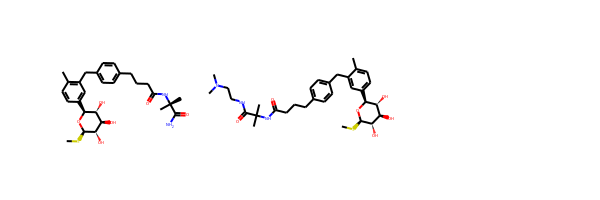

In [44]:
Draw.MolsToGridImage([a,results[1]])

In [43]:
a=copy(results[0])
AllChem.Compute2DCoords(a)

0

In [42]:
results[0].GetNumAtoms(), results[1].GetNumAtoms()

(37, 42)

In [16]:
results

In [29]:
results[0],results[2]

('MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPAGPGTPPPDSGPLAKDDRAARGQPASDTDGLDSVEAAAPPPILSSSVEWSTSGERSASARFPATGPGSSDDEDDDEDEHGGVFSQSFLPASDSESDIIFDNEDENSKSQNQDEDCNEKNGCHESEPSVTTEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRDLKPVNIFLDSDDHVKIGDFGLATDHLAFSADSKQDDQTGDLIKSDPSGHLTGMVGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKS

In [38]:
results[1]

{'A': 'SRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRNLKPVNIFLDSDDHVKIGDFGLIKSDPSGHLTGMVGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKSELLPPP',
 'B': 'SRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRNLKPVNIFLDSDDHVKIGDFGLDLIKSDPSGHLTGMVGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKSELLPPPQM',
 'C': 'SRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPVTTEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRNLKPVNIFLDSDDHVKIGDFGLATDHGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKSELLPPPQM',
 'D': 'SRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRNLKPVNIFLDSDDHVKIG

In [30]:
calc_seq_align_identity(results[0],results[1]["A"])

0.9962825278810409

In [31]:
Needleman_Wunsch_alignment(results[0],results[1]["A"])

('MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPAGPGTPPPDSGPLAKDDRAARGQPASDTDGLDSVEAAAPPPILSSSVEWSTSGERSASARFPATGPGSSDDEDDDEDEHGGVFSQSFLPASDSESDIIFDNEDENSKSQNQDEDCNEKNGCHESEPSVTTEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRDLKPVNIFLDSDDHVKIGDFGLATDHLAFSADSKQDDQTGDLIKSDPSGHLTGMVGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKS

In [37]:
write_alignment(results[0],results[1]["A"],"test.txt")

In [33]:
with open("test.txt", "w") as f:
    f.write('\033[31m' + 'This text is red\033[0m')


OC(=O)CCCN1CCc2cccc(OCCc3cccc4ccccc34)c2CC1 value                                                    50
smiles          OC(=O)CCCN1CCc2cccc(OCCc3cccc4ccccc34)c2CC1
seq       MESGLLRPAPVSEVIVLHYNYTGKLRGARYQPGAGLRADAVVCLAV...
Name: 7YXA, dtype: object


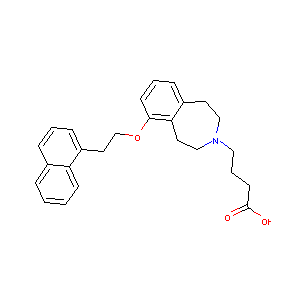

In [15]:
a="7YXA"
print(df.loc[a]["smiles"],df.loc[a])
Draw.MolToImage(Chem.MolFromSmiles(df.loc[a]["smiles"]))

In [150]:
print(df.loc["6LR4"]["seq"])

MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGHPEPLSNGRPQGNSRQVVEQDEEEDEELTLKYGAKHVIMLFVPVTLCMVVVVATIKSVSFYTRKDGQLIYTPFTEDTETVGQRALHSILNAAIMISVIVVMTILLVVLYKYRCYKVIHAWLIISSLLLLFFFSFIYLGEVFKTYNVAVDYITVALLIWNFGVVGMISIHWKGPLRLQQAYLIMISALMALVFIKYLPEWTAWLILAVISVYDLVAVLCPKGPLRMLVETAQERNETLFPALIYSSTMVWLVNMAEGDPEAQRRVSKNSKYNAESTERESQDTVAENDDGGFSEEWEAQRDSHLGPHRSTPESRAAVQELSSSILAGEDPEERGVKLGLGDFIFYSVLVGKASATASGDWNTTIACFVAILIGLCLTLLLLAIFKKALPALPISITFGLVFYFATDYLVQPFMDQLAFHQFYI


In [17]:
ref_mol,ligands=process_pdb("8DD3")

Structure exists: 'dataset/8DD3/pdb8dd3.ent' 
Warning! Best matched ligand is not similar for 8DD3!
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16901408450704225, 0.16901408450704225, 0.14035087719298245, 0.5393258426966292, 0.16901408450704225, 0.14035087719298245, 0.5882352941176471, 0.5882352941176471]


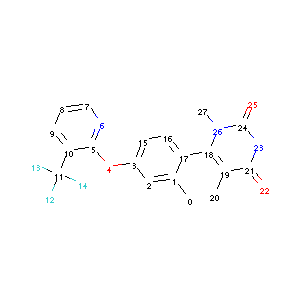

In [74]:
new_mol=copy(ref_mol)
for atom in new_mol.GetAtoms():
    atom.SetProp('atomIndex', str(atom.GetIdx()))
Draw.MolToImage(new_mol, includeAtomNumbers=True)

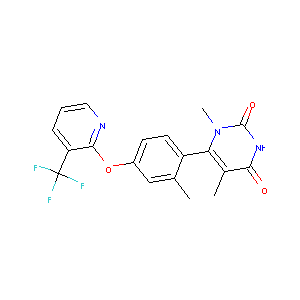

In [77]:
Draw.MolToImage(ref_mol)

In [72]:
Chem.RemoveHs(ref_mol,sanitize=False).GetNumAtoms()

28

In [66]:
proc_ligs = []
for lig in ligands:
    AllChem.Compute2DCoords(lig)
    proc_ligs.append(Chem.RemoveHs(lig,sanitize=False))

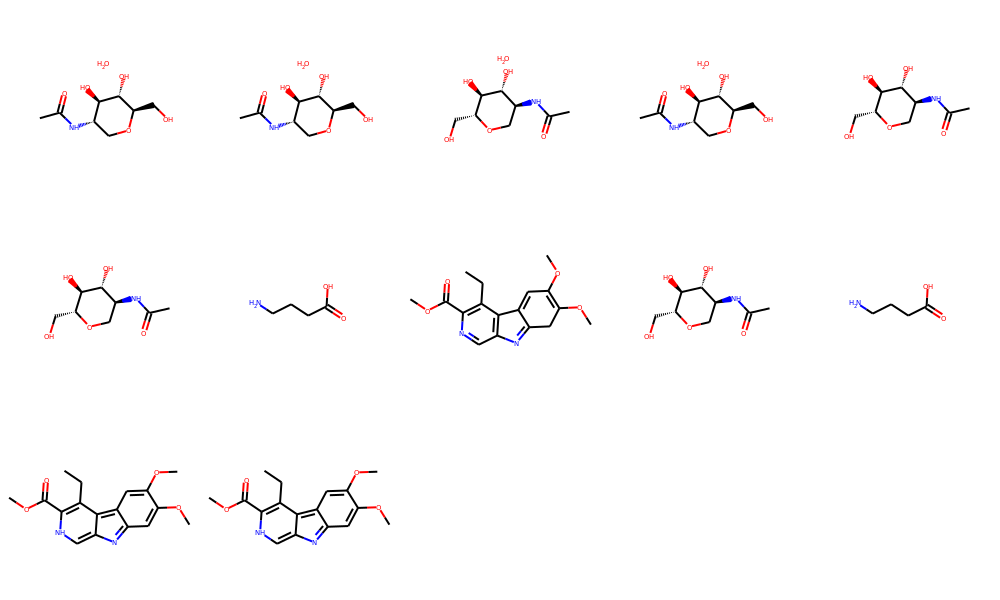

In [67]:
Draw.MolsToGridImage(proc_ligs, molsPerRow=5, subImgSize=(200, 200))

In [71]:
proc_ligs[-1].GetNumAtoms()

23

In [181]:
disordered_atoms =[]
for atom in a.get_atoms():
    if atom.is_disordered():
        disordered_atoms.append(atom)

In [182]:
for residue in a.get_residues():
    print(residue.get_unpacked_list())

[<Atom N>, <Atom CA>, <Atom C>, <Atom O>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD1>, <Atom CD2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom SD>, <Atom CE>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>, <Atom OE1>, <Atom NE2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD1>, <Atom CD2>, <Atom CE1>, <Atom CE2>, <Atom CZ>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom OG1>, <Atom CG2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD1>, <Atom CD2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG1>, <Atom CG2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD>, <Atom NE>, <Atom CZ>, <Atom NH1>, <Atom NH2>]
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom CG>, <Atom CD1>, <Atom CD2>]
[<Atom N>, <Atom CA>, <Atom C>, <Ato

In [183]:
io = PDB.PDBIO()
io.set_structure(a)
io.save(f"dataset/5SIJ/protein.pdb", AAOnly())

AttributeError: 'Atom' object has no attribute 'disordered_get_list'

In [149]:
for pdbid in df.index:
    print(pdbid, process_pdb(pdbid))

Structure exists: 'dataset/6TRX/pdb6trx.ent' 
6TRX {'PO4', 'TMO', '9XH'}
Structure exists: 'dataset/7LQZ/pdb7lqz.ent' 
7LQZ {'POV', '6EU'}
Structure exists: 'dataset/7T6S/pdb7t6s.ent' 
7T6S {'FUI'}
Structure exists: 'dataset/7SHV/pdb7shv.ent' 
7SHV {'29L'}
Structure exists: 'dataset/6LR4/pdb6lr4.ent' 
6LR4 {'NAG', 'BMA', 'PC1', 'ESF', 'CLR'}
Structure exists: 'dataset/7Y5T/pdb7y5t.ent' 
7Y5T {'NAG', 'BMA', 'PC1', 'IGD', 'CLR'}
Structure exists: 'dataset/7DMC/pdb7dmc.ent' 
7DMC {'H9F'}
Structure exists: 'dataset/7B91/pdb7b91.ent' 
7B91 {'T2Z'}
Structure exists: 'dataset/7QQ6/pdb7qq6.ent' 
7QQ6 {'38O'}
Structure exists: 'dataset/7X5H/pdb7x5h.ent' 
7X5H {'8K3'}
Structure exists: 'dataset/7XTB/pdb7xtb.ent' 
7XTB {'SRO'}
Structure exists: 'dataset/7QNE/pdb7qne.ent' 
7QNE {'NAG', 'BMA', 'MAN', 'EIE', 'PIO', 'D10', 'OCT'}
Structure exists: 'dataset/7E9H/pdb7e9h.ent' 
7E9H set()
7MU5 {'TLI'}
7EJ8 {'J59'}
7JVR {'08Y'}
7CX2 {'P2E'}
7CMV {'G6O'}
7EJ0 {'E5E'}
7EJK {'J5C'}
7CMU {'G6L'}
7DFL {'HSM'}

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/7SFD/pdb7sfd.ent'

In [132]:
pdbid

'7E9H'

In [28]:
pdbid="7E9H"
process_pdb(pdbid)

Structure exists: 'dataset/7E9H/pdb7e9h.ent' 
Warning! No ligands found for 7E9H!


In [29]:
struc=parser.get_structure(pdbid, f"dataset/{pdbid}/pdb{pdbid.lower()}.ent")

In [30]:
struc[0].child_dict

{'R': <Chain id=R>,
 'S': <Chain id=S>,
 'A': <Chain id=A>,
 'B': <Chain id=B>,
 'C': <Chain id=C>,
 'D': <Chain id=D>}

In [31]:
# get chain sequences
seqs={}
for chain in struc[0].child_dict.values():
    seqs[chain.id]="".join([PDB.Polypeptide.three_to_one(res.get_resname()) for res in chain.get_residues() if PDB.Polypeptide.is_aa(res, standard=True)])

In [32]:
seqs

{'R': 'NSIRIDGDITLGGLFPVHGRGSEGKPCGELKKEKGIHRLEAMLFALDRINNDPDLLPNITLGARILDTCSRDTHALEQSLTFVQALIERVVGVIGASGSSVSIMVANILRLFKIPQISYASTAPDLSDNSRYDFFSRVVPSDTYQAQAMVDIVRALKWNYVSTVASEGSYGESGVEAFIQKSREDGGVCIAQSVKIPREPKAGEFDKIIRRLLETSNARAVIIFANEDDIRRVLEAARRANQTGHFFWMGSDSWGSKIAPVLHLEEVAEGAVTILPKRMSVRGFDRYFSSRTLDNNRRNIWFAEFWEDNFHCKLVKKCTNRERIGQDSAYEQEGKVQFVIDAVYAMGHALHAMHRDLCPGRVGLCPRMDPVDGTQLLKYIRNVNFSGIAGNPVTFNENGDAPGRYDIYQYQLRAEYKVIGSWTDHLHLRIQQLPRSICSLPCQPGERKKTVKGMPCCWHCEPCTGYQYQVDRYTCKTCPYDMRPTENRTGCRPIPIIKLEWGSPWAVLPLFLAVVGIAATLFVVITFVRYNDTPIVKASGRELSYVLLAGIFLCYATTFLMIAEPDLGTCSLRRIFLGLGMSISYAALLTKTNRIYRIFEQGKRSVSAPRFISPASQLAITFSLISLQLLGICVWFVVDPSHSVVDFQDQRTLDPRFARGVLKCDISDLSLICLLGYSMLLMVTCTVYAIKTRGVPETFNEAKPIGFTMYTTCIVWLAFIPIFFGTSQSADKLYIQTTTLTVSVSLSASVSLGMLYMPKVYIILFH',
 'S': 'NSIRIDGDITLGGLFPVHGRGSEGKPCGELKKEKGIHRLEAMLFALDRINNDPDLLPNITLGARILDTCSRDTHALEQSLTFVQALERVVGVIGASGSSVSIMVANILRLFKIPQISYASTAPDLSDNSRYDFFSRVVPSDTYQAQAMVDIVRALKWNYVSTVASEGSYGESGVEAFIQKSREDGGVCIAQSVKIPREPKAGEFDKIIRRLLETSNA

In [112]:


# get ligand from pdb
interesting_ligand_id = 0
for residue in struc[0].get_residues():
    if not PDB.Polypeptide.is_aa(residue, standard=True):
        if residue.get_resname() not in ignored_list and len(residue.child_list) > 1:
            # save residue as ligand
            copied_res = residue.copy()
            io = PDB.PDBIO()
            io.set_structure(copied_res)
            io.save(f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.pdb")
            subprocess.call(["obabel", f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.pdb", "-O", f"dataset/{pdbid}_IP/lig_{interesting_ligand_id}.sdf"])
            interesting_ligand_id += 1


In [113]:
ligands = []
for i in range(interesting_ligand_id):
    mol = Chem.MolFromMolFile(f"dataset/{pdbid}/lig_{i}.sdf", sanitize=False)
    Chem.rdmolops.SanitizeMol(mol, 268435455-2)
    ligands.append(mol)


In [114]:
ref_mol=Chem.MolFromSmiles(df.loc[pdbid]["smiles"])
ref_mol_fp=AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=1024)

In [115]:
# get all similarities
similarity = [Chem.DataStructs.DiceSimilarity(ref_mol_fp, AllChem.GetMorganFingerprintAsBitVect(ligand, 2,nBits=1024)) for ligand in ligands]
# Chem.DataStructs.DiceSimilarity(ref_mol_fp, AllChem.GetMorganFingerprintAsBitVect(ligand, 2,nBits=1024)) for ligand in ligands

In [116]:
similarity

[0.6229508196721312]

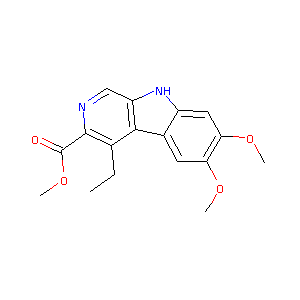

In [97]:
Draw.MolToImage(ref_mol)

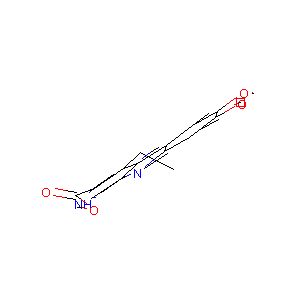

In [102]:
# AllChem.Compute2DCoords(ligands[-1])
Draw.MolToImage(ligands[-1])

In [103]:
fixmol=AllChem.AssignBondOrdersFromTemplate(refmol=ref_mol, mol=ligands[-1])

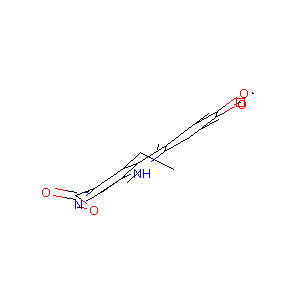

In [104]:
Draw.MolToImage(fixmol)

In [95]:
ref_mol.GetNumAtoms()

23

In [96]:
ligands[-1].GetNumAtoms()

23

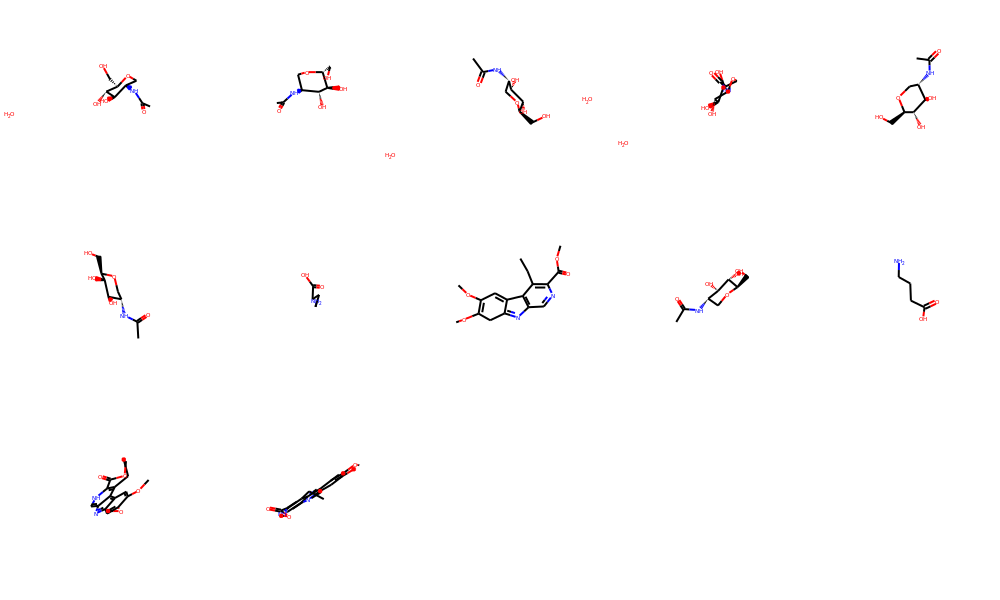

In [65]:
Draw.MolsToGridImage(ligands, molsPerRow=5, subImgSize=(200, 200))

In [47]:
chosen_ligand_idx = np.argmax(similarity)

In [117]:
ref_chain_seq = df.loc[pdbid]["seq"]
seq_sims = {}
for chain_id in seqs:
    seq_sims[chain_id] = calc_seq_align_identity(ref_chain_seq, seqs[chain_id])

In [118]:
seq_sims

{'A': 0.2855191256830601}

In [121]:
(ref_chain_seq in seqs[chain_id]) or (seqs[chain_id] in ref_chain_seq)

True

In [51]:
satisfied_chains = []
satisfied_chain_sims = []
for seqid in seqs:
    if len(seqs[seqid]) == 0:
        continue
    min_dist = get_min_dist_between_lig_and_chain(ligands[chosen_ligand_idx], struc[0][seqid])
    if min_dist > min_dist_threshold:
        continue
    satisfied_chains.append(seqid)
    satisfied_chain_sims.append(seq_sims[seqid])


In [52]:
satisfied_chains, satisfied_chain_sims

(['C', 'D'], [0.30701754385964913, 0.7280701754385965])

In [120]:
selected_chain=satisfied_chains[np.argmax(satisfied_chain_sims)]

In [121]:
chosen_ligand_idx, selected_chain

(1, 'B')

In [56]:
class AAOnly(Select):
    def accept_residue(self, residue):
        return PDB.Polypeptide.is_aa(residue)

# io = PDB.PDBIO()
# io.set_structure(struc[0][selected_chain])
# io.save(f"dataset/{pdbid}/protein.pdb", AAOnly())

save_multiple_chains([struc[0]["C"], struc[0]["D"]], f"dataset/{pdbid}/protein.pdb", AAOnly())

In [55]:
from Bio.PDB.StructureBuilder import StructureBuilder

def save_multiple_chains(list_of_chains, save_addr, selector=None):
    sb = StructureBuilder()
    sb.init_structure("pdb")
    sb.init_seg(" ")
    sb.init_model(0)
    
    for chain in list_of_chains:
        sb.structure[0].add(chain)

    io = PDB.PDBIO()
    io.set_structure(sb.structure)
    io.save(save_addr, select=selector)

In [113]:
def get_min_dist_between_lig_and_chain(ligand, chain):
    ligand_coords = ligand.GetConformer().GetPositions()
    chain_CA_coords = np.array([res["CA"].get_coord() for res in chain if PDB.Polypeptide.is_aa(res)])
    # minimum distance between ligand and chain
    min_dist = np.min(np.linalg.norm(ligand_coords[:, None, :] - chain_CA_coords[None, :, :], axis=-1))
    return min_dist


In [97]:
min_dist

3.607272607336432

In [88]:
a=struc[0]["A"][50]["CA"]

In [89]:
a.get_coord()

array([-82.822,  11.066,  10.95 ], dtype=float32)

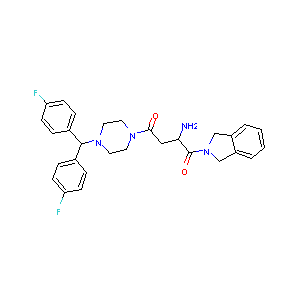

In [53]:
Draw.MolToImage(ref_mol)

In [153]:
AllChem.Compute2DCoords(ligands[1])

0

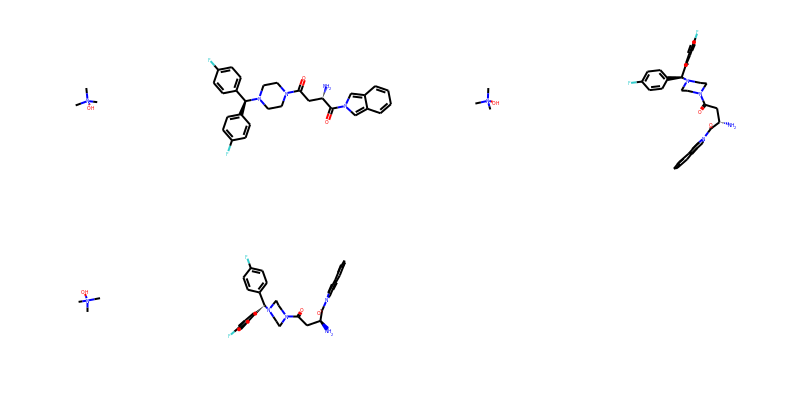

In [154]:
Draw.MolsToGridImage(ligands, molsPerRow=4, subImgSize=(200, 200))

In [ ]:
# convert ligand to smiles
import subprocess
import os

def get_smiles(pdbid, ligand_id):
    os.chdir(f"dataset/{pdbid}")
    subprocess.call(["obabel", f"lig_{ligand_id}.pdb", "-O", f"lig_{ligand_id}.sdf"])
    subprocess.call(["obabel", f"lig_{ligand_id}.sdf", "-O", f"lig_{ligand_id}.smi"])
    with open(f"lig_{ligand_id}.smi", "r") as f:
        smiles = f.readline().split()[0]
    os.chdir("../

In [35]:
copied_res

<Residue TMO het=H_TMO resseq=1001 icode= >

In [20]:
ligand

<Residue LEU het=  resseq=48 icode= >

# Final dataset

In [2]:
import pandas as pd
df_final=pd.read_csv("bindingDB_processed.csv",index_col=0)

In [16]:
df_final=pd.read_csv("prepared_final.csv",index_col=0)

In [36]:
df_final["accurate"]=~df_final.value.str.contains('<')

In [42]:
df_final["pKa"]=-np.log10(df_final.value.apply(lambda x: float(x.replace("<","")))*1e-9)

In [45]:
df_final.to_csv("bindingDB_processed.csv")

In [32]:
items = set()
for v in df_final.value:
    items.update(set(v))


In [33]:
items

{' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<'}

In [31]:

a="100"
b="100.0"
c="<100"


print(a.isalnum(), b.isalnum(), c.isalnum())

True False False


In [3]:
vina=pd.read_csv("vina_rescores.csv",index_col=0)
new_vina_rescore=pd.read_csv("vina_modified_rescores.csv",index_col=0)

In [4]:
comparison=df_final.join(vina).join(new_vina_rescore)
comparison.columns

Index(['value', 'smiles', 'seq', 'accurate', 'pKa', 'vina_score',
       'vina_modified_score'],
      dtype='object')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import spearmanr

In [10]:
filter=comparison.accurate

In [16]:
comparison.shape

(130, 7)

corr 0.21833055523319173
mae 2.5547274225836216
bias 2.1602022424842104
mae_no_bias 1.93283336087841


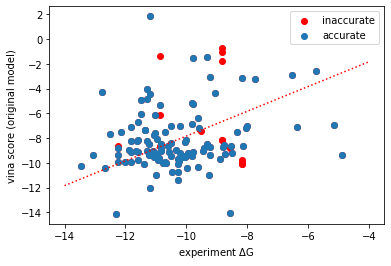

In [31]:
xs_filtered=comparison.pKa[filter]*-1.36
ys_filtered=comparison.vina_score[filter]
bias=ys_filtered.mean()-xs_filtered.mean()

xs=comparison.pKa*-1.36
ys=comparison.vina_score

plt.scatter(xs,ys, c="red", label="inaccurate")
plt.scatter(xs_filtered,ys_filtered,label="accurate")
plt.plot([-14,-4],[-14+bias,-4+bias], "r:")
corr=np.corrcoef(xs_filtered,ys_filtered)[0,1]
mae=np.mean(np.abs(xs_filtered-ys_filtered))
mae_no_bias=np.mean(np.abs(xs_filtered-ys_filtered+bias))

print("corr", corr)
print("mae", mae)
print("bias", bias)
print("mae_no_bias", mae_no_bias)
plt.xlabel("experiment $\Delta$G")
plt.ylabel("vina score (original model)")
plt.legend()

corr 0.2888701132929025
mae 1.7439601767981538
bias 1.0274544163972532
mae_no_bias 1.4849228465386393


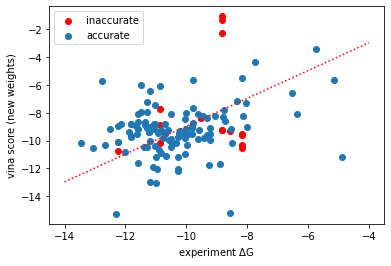

In [35]:
xs=comparison.pKa[filter]*-1.36
ys=comparison.vina_modified_score[filter]
bias=ys.mean()-xs.mean()

xs_rest=comparison.pKa[~filter]*-1.36
ys_rest=comparison.vina_modified_score[~filter]

plt.scatter(xs_rest, ys_rest,c="red", label="inaccurate")
plt.scatter(xs,ys,label="accurate")
plt.plot([-14,-4],[-14+bias,-4+bias], "r:")
corr=np.corrcoef(xs,ys)[0,1]
mae=np.mean(np.abs(xs-ys))
mae_no_bias=np.mean(np.abs(xs-ys+bias))

print("corr", corr)
print("mae", mae)
print("bias", bias)
print("mae_no_bias", mae_no_bias)

plt.xlabel("experiment $\Delta$G")
plt.ylabel("vina score (new weights)")
plt.legend()


In [14]:
comparison[["vina_score", "vina_modified_score"]].to_csv("/home/jerry/data/pdbbind/resplit_results/bindingDB/vina_bindingDB.csv")